# Este notebook tiene como objetivo reproducir algunos articulos que ayuden al entendimientos de la simulación de pulsos dentro de una cavidad.

In [44]:
# LIBRERIAS
import matplotlib
import numpy as np
import matplotlib.pylab as plt
import celluloid as cell  #animations
import os
from scipy.interpolate import CubicSpline

%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

path=os.getcwd()



def fourierT(f):

    return np.fft.fftshift(np.fft.fft(np.fft.fftshift(f)))



def fourierI(f):

    return np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f)))

# Tesis

In [45]:
def fibraerbio(u0,dt,dz2,nz2,gain,PL,Tr,omega,loss,q0,Ea,ta1,D2,gamma2):
    
    global gahno, halfstep1, as_ 
    
    nt=len(u0)
    L=nt*dt
    t=np.linspace(-L/2,L/2,nt)
    dw= 2*np.pi/(nt*dt)
    V = np.array([j*dw for j in range(-int(nt/2), int(nt/2))])
    V=np.fft.fftshift(V)
    gahno=gain*np.exp(-np.trapz(np.abs(u0)**2,t)/(PL*Tr))
    halfstep1= gahno-loss+gahno/omega**2*(1j*V)**2-1j*D2/2*(1j*V)**2
    halfstep=np.exp(halfstep1*dz2/2)
    u1=u0
    
    for iz in range(1,nz2):
        
        ufft1= np.fft.fft(u1)
        uhalf1=np.fft.ifft(halfstep*ufft1)
        as1=(np.abs(u1)**2+np.abs(u0)**2)/2
        as_=q0/(1+as1/(Ea/ta1))
        uv1=uhalf1*np.exp((-as_+1j*gamma2*as1)*dz2)
        uv1=np.fft.fft(uv1)
        ufft1=halfstep*uv1
        uv1=np.fft.ifft(ufft1)
        u1=uv1
        
    return u1
        
        
def fibrasmf(u0,dt,dz1,nz1,D1,gamma1,alpha):

    global halfstep1
    nt=len(u0)
    L=nt*dt
    t=np.linspace(-L/2,L/2,nt)
    dw= 2*np.pi/(nt*dt)
    w = np.array([j*dw for j in range(-int(nt/2), int(nt/2))])
    w=np.fft.fftshift(w)
    halfstep1 = - alpha - 1j*(D1/2)*((1j*w)**2);
    halfstep = np.exp(halfstep1*dz1/2);
    u1 = u0;

    for iz in range(1,nz1):
        
        ufft1 = np.fft.fft(u1);
        uhalf1 =np.fft.ifft(halfstep*ufft1);
        as1 = ((np.abs(u1)**2 + np.abs(u0)**2)/2);
        uv1 = uhalf1*np.exp((1j*gamma1*as1)*dz1);
        uv1 =np.fft.fft(uv1);
        ufft1 = halfstep*uv1;
        uv1 = np.fft.ifft(ufft1);
        u1 = uv1;
    
    return u1
    
        
def Delta_landa1(y_data,x_data):

    
    cs=CubicSpline(x_data,y_data)
    new_xdata=np.linspace(min(x_data),max(x_data),len(x_data)*3)
    Y=cs(new_xdata)
    medium_value=np.max(Y)*0.01
    M_V=[]
    wl_s=[]
    pow_s=[]
    
    for i in range(len(Y)):
        if Y[i]>medium_value:
            
            M_V.append(i)
            wl_s.append(new_xdata[i])
            pow_s.append(Y[i])
            

    x1=new_xdata[np.min(M_V)]; 
    x2=new_xdata[np.max(M_V)]
    return abs(x2-x1)


Text(0, 0.5, 'Power/W')

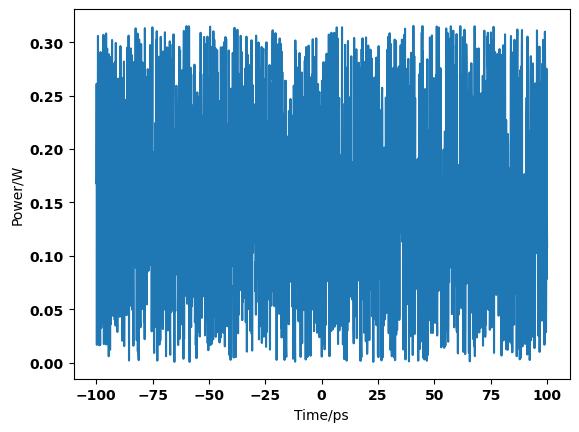

In [10]:
T = 200
nt = 2**11
dt = T/nt
t = np.linspace(-T/2,T/2,nt)
dw= 2*np.pi/(nt*dt)
w = np.array([j*dw for j in range(-int(nt/2), int(nt/2))])
luz = 299792458
wl = 1550

# PARAMETROS DA FIBRA SMF
z1 = 4
nz1 = 100
dz1 = z1/nz1
alpha = 0
D11 = 17
D1 = -(D11*wl**2/(2*np.pi*luz))  #% beta2 (ps^2/m)
gamma1 = 3e-3 #; % parametro de nao-linearidade

#% PARAMETROS DA FIBRA DE ERBIO
z2 = 1 
nz2 = 100
dz2 = z2/nz2
Tr = ((((z1+z2)*1.45)/luz))*1e12  # 

if (Tr > 43600):
    Tr = 43000
else:
    Tr = Tr

loss = 0
gain = 1.44 #; % coeficiente de ganho (m^-1)
PL = 0.534*1e-3 #; % potencia de saturaçao do
omega = 2*np.pi*3.75 #; % largura de banda do ganho
OK = Tr*PL
D21 = -14  #; % parametro de dispersão (GVD)
D2 = -(D21*wl**2/(2*np.pi*luz)) # % beta2 (ps^2/m)
gamma2 = 3e-3 #; % parametro de nao-linearidade

# %PARAMETROS DO ABSORVEDOR SATURAVEL
q0 = 1 #; % indice do absorvedor
Ea = 1.34 #; % energia de saturação (pJ)
tal = 0.1 #; % tempo de recuperação (ps)
voltas = 600 #; % numero de voltas na cavidade
#% PROPAGAÇÃO NA CAVIDADE
P0 = 0.1;
FWHM = 2;
tp0 = FWHM/(2*np.sqrt(np.log(2)));
A = np.random.uniform(low=0.0005, high=np.sqrt(P0), size=nt) # Seed
u=np.zeros((voltas,nt),dtype=complex)
u[0,:] = A

plt.plot(t,np.abs(A))
plt.xlabel('Time/ps')
plt.ylabel('Power/W')

In [11]:
for ii in range(1,voltas):
    u[ii,:] = fibrasmf(u[ii-1,:],dt,dz1,nz1,D1,gamma1,alpha);
    u[ii,:] = fibraerbio(u[ii,:],dt,dz2,nz2,gain,PL,Tr,omega,loss,q0,Ea,tal,D2,gamma2);

Text(0.5, 0, 'Time/ps')

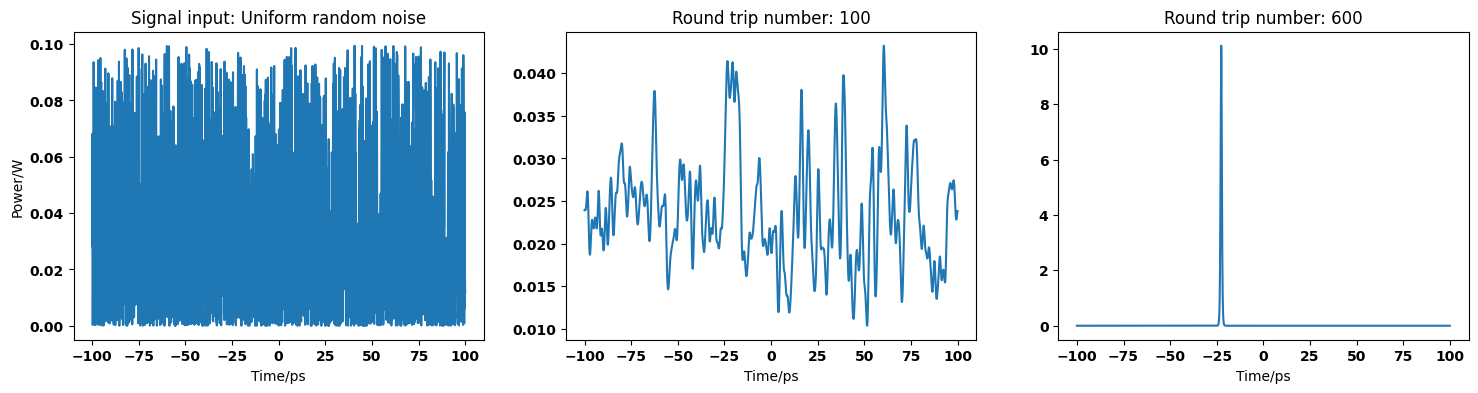

In [19]:
f=plt.figure(figsize=(18,4))

plt.subplot(131)
plt.plot(t,np.abs(u[0,:])**2)
plt.title('Signal input: Uniform random noise')
plt.xlabel('Time/ps')
plt.ylabel('Power/W')

plt.subplot(132)
plt.plot(t,np.abs(u[100,:])**2)
plt.title('Round trip number: 100')
plt.xlabel('Time/ps')

plt.subplot(133)
plt.plot(t,np.abs(u[-1,:])**2)
plt.title('Round trip number: 600')
plt.xlabel('Time/ps')

([<matplotlib.axis.XTick at 0x7f2b996bc1c0>,
 [Text(0, 0, '-100.0'),
  Text(409, 0, '-60.0'),
  Text(818, 0, '-20.0'),
  Text(1227, 0, '20.0'),
  Text(1636, 0, '60.0'),
  Text(2045, 0, '100.0')])

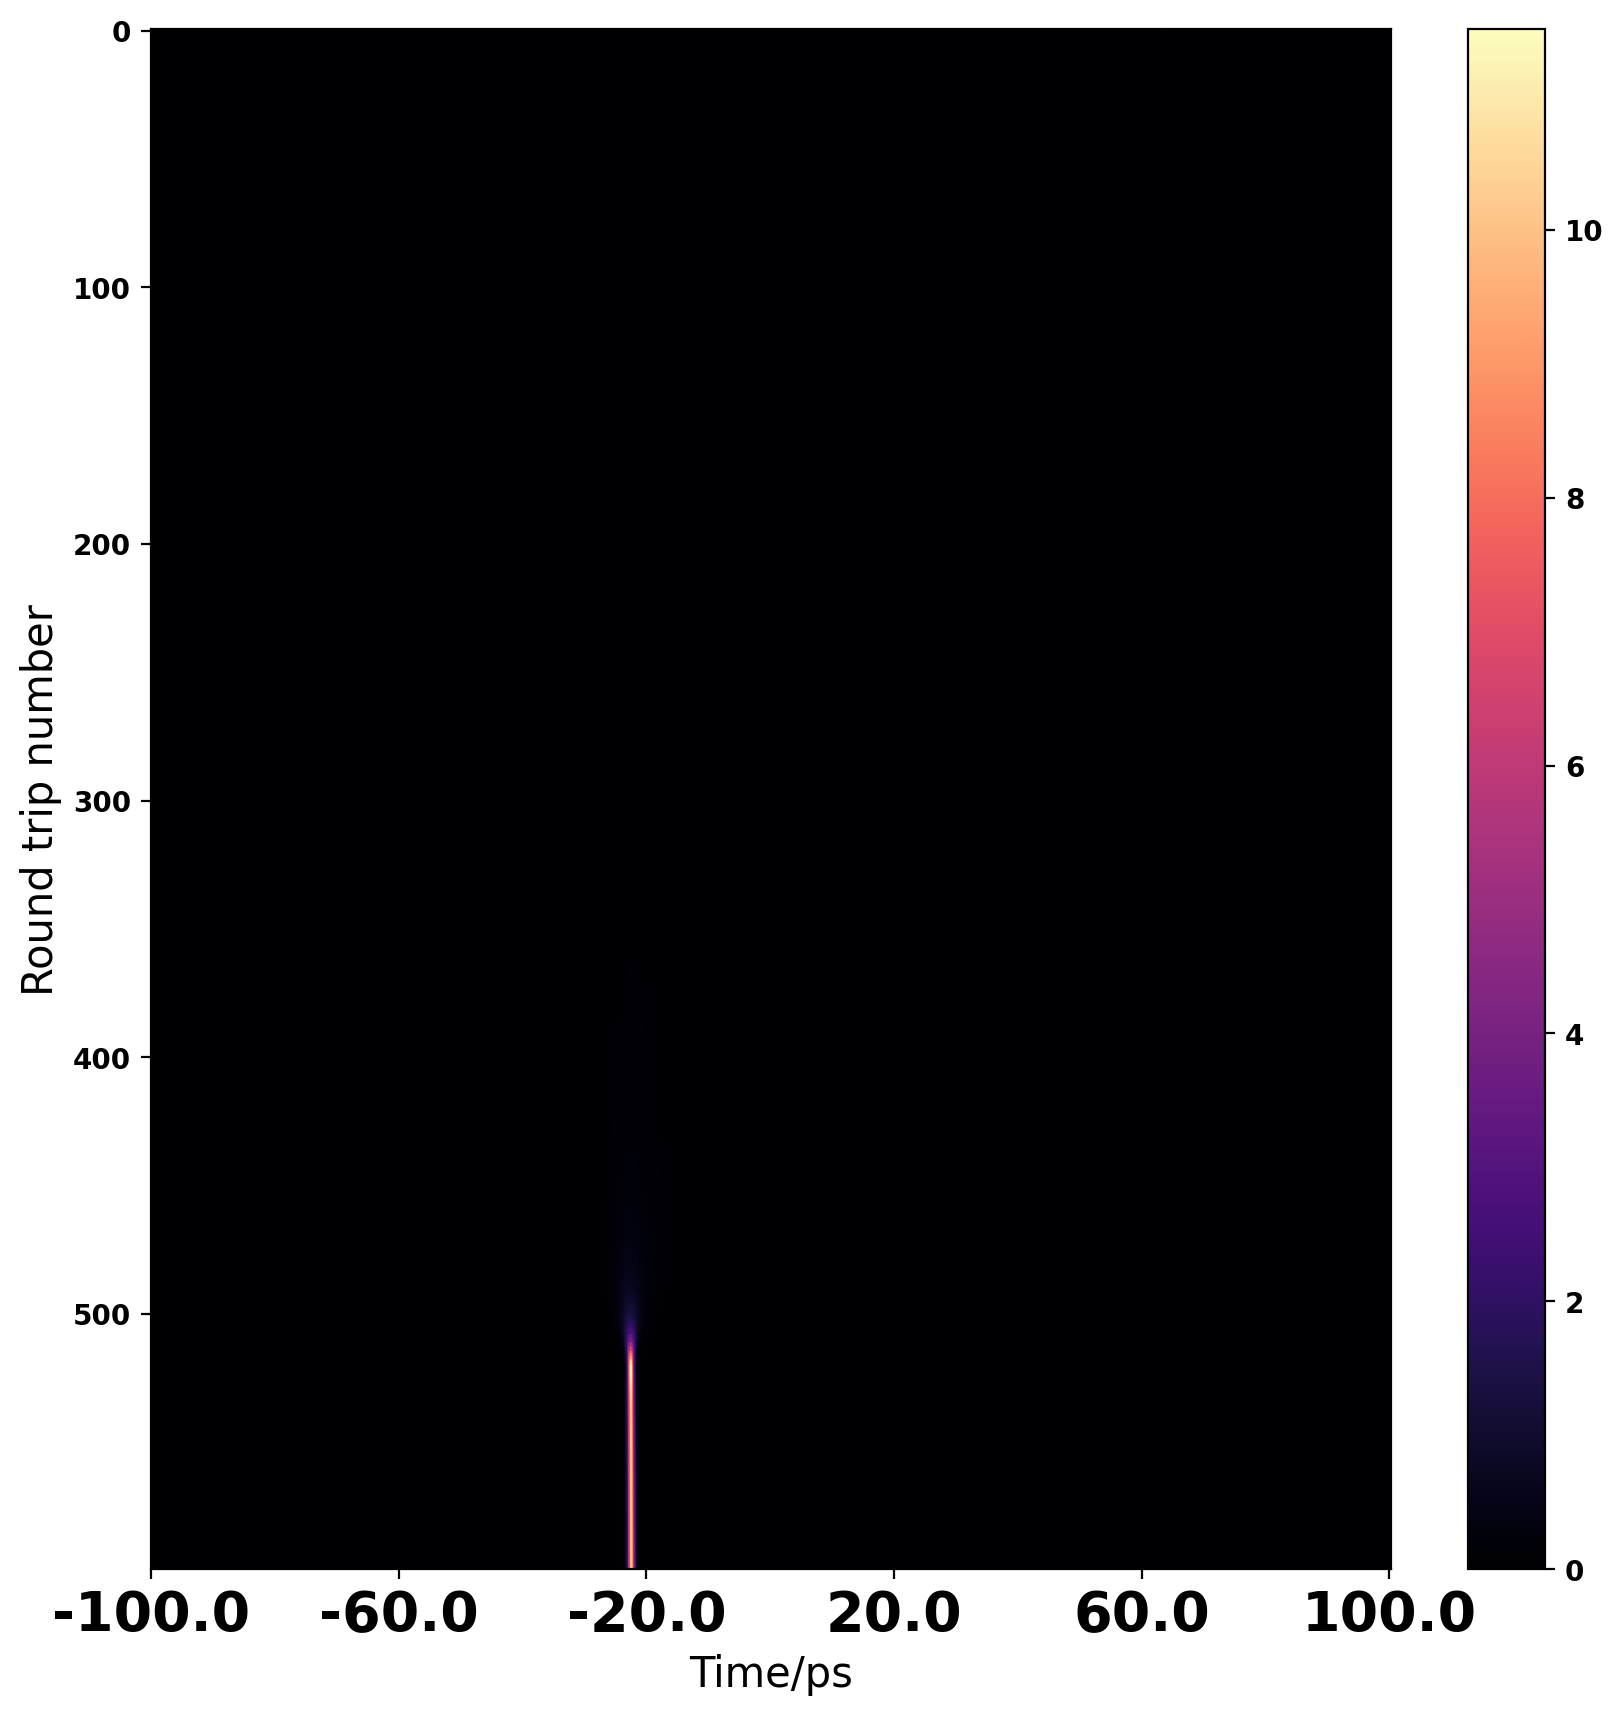

In [24]:
f=plt.figure(figsize=(10,10),dpi=200)


plt.imshow(np.abs(u)**2, cmap='magma',interpolation='nearest', aspect='auto')
plt.xlabel('Time/ps',fontsize=15)
plt.ylabel('Round trip number',fontsize=15)
plt.colorbar()

nx = t.shape[0]
no_labels = 6 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round((t)[::step_x],0) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)




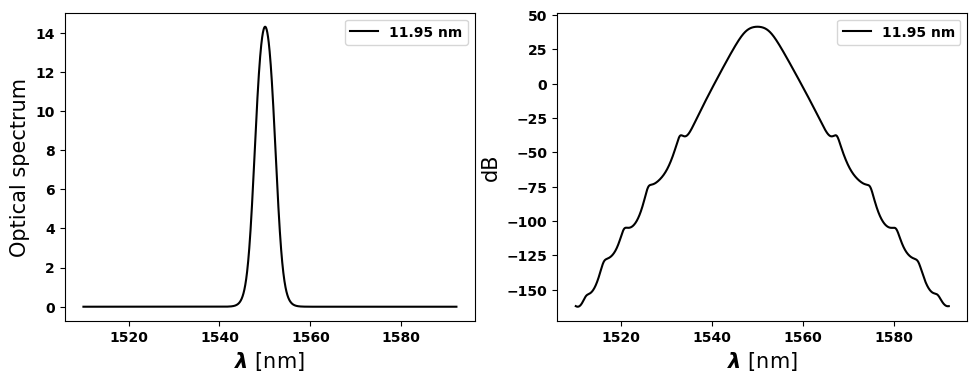

In [59]:
f=plt.figure(figsize=(18,4))

w0=(2*np.pi*luz)/(wl*1e-9)
dw= 2*np.pi/(nt*dt*1e-12)
w = np.array([j*dw for j in range(-int(nt/2), int(nt/2))])
w=w+w0
WL=np.sort((2*np.pi*luz)/w)
delt=Delta_landa1(np.abs(fourierT(u[-1,:]))**2,WL)

plt.subplot(131)
plt.plot(WL*1e9,np.abs(fourierT(u[-1,:])*dt)**2,'k',label=str(round(delt*1e9,2))+' nm')

plt.xlabel('$\lambda$ [nm]',fontsize=15)
plt.ylabel('Optical spectrum',fontsize=15)
plt.legend()


plt.subplot(132)
plt.plot(WL*1e9,10*np.log10(np.abs(fourierT(u[-1,:])*dt)**2/1e-3),'k',label=str(round(delt*1e9,2))+' nm')
plt.xlabel('$\lambda$ [nm]',fontsize=15)
plt.ylabel('dB',fontsize=15)
plt.legend()


/tmp/ipykernel_6219/839933501.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(fourierT(u))**2), cmap='hot',interpolation='nearest', aspect='auto')


([<matplotlib.axis.XTick at 0x7f2b98bbdba0>,
 [Text(0, 0, '1510.0'),
  Text(409, 0, '1526.0'),
  Text(818, 0, '1542.0'),
  Text(1227, 0, '1558.0'),
  Text(1636, 0, '1575.0'),
  Text(2045, 0, '1592.0')])

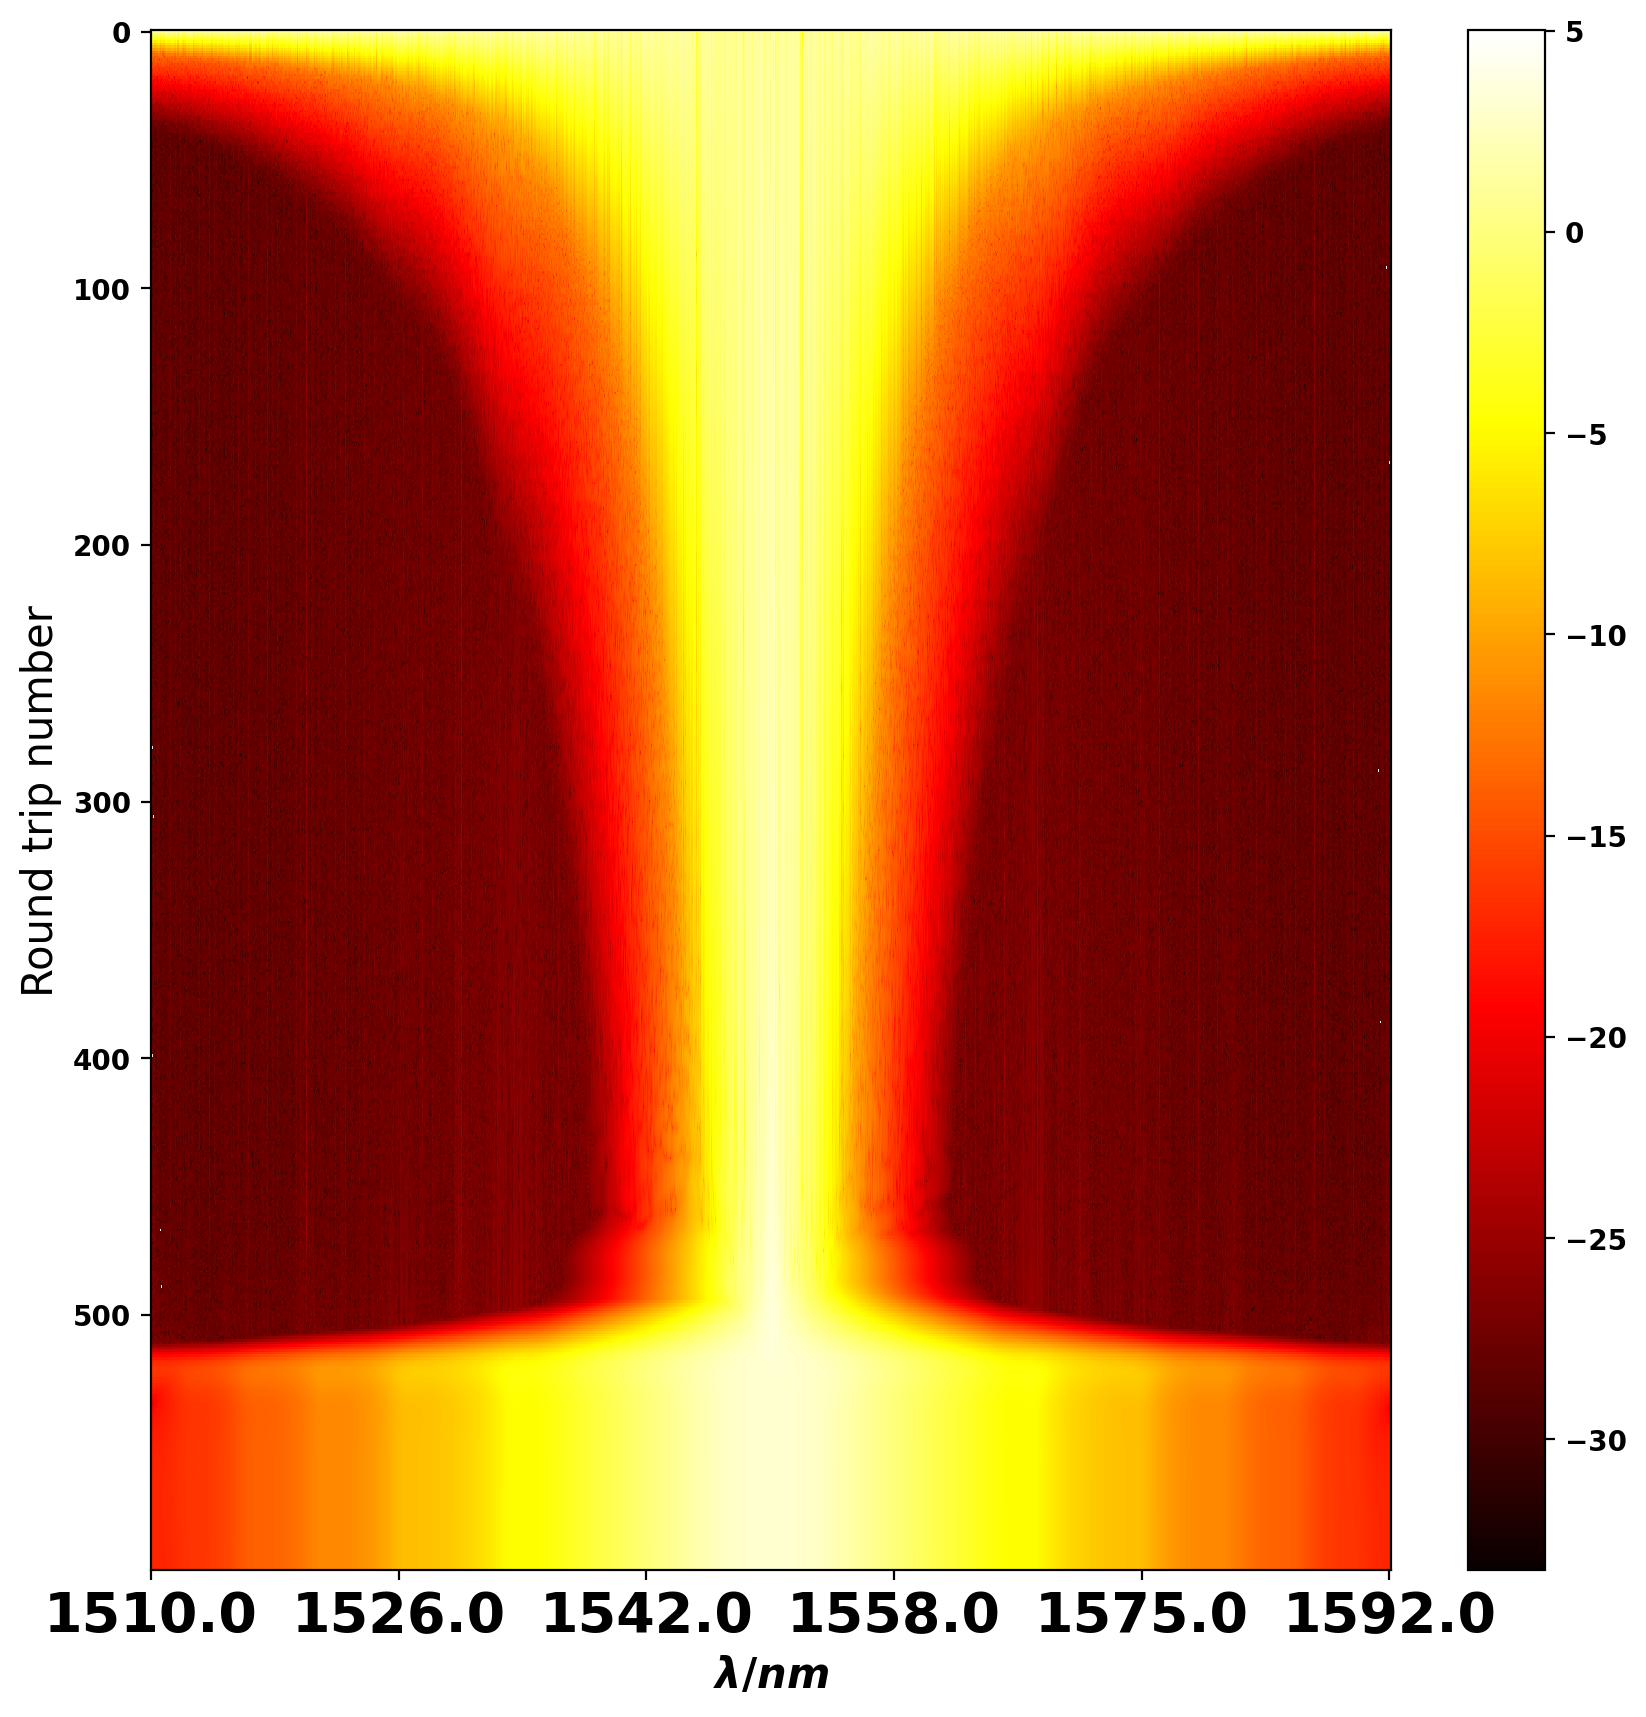

In [43]:
f=plt.figure(figsize=(10,10),dpi=200)


plt.imshow(np.log10(np.abs(fourierT(u))**2), cmap='hot',interpolation='nearest', aspect='auto')
plt.xlabel('$\lambda/nm$',fontsize=15)
plt.ylabel('Round trip number',fontsize=15)
plt.colorbar()


nx = (WL*1e9).shape[0]
no_labels = 6 # how many labels to see on axis x
step_x = int(nx / (no_labels - 1)) # step between consecutive labels
x_positions = np.arange(0,nx,step_x) # pixel count at label position
x_labels = np.round(((WL*1e9))[::step_x],0) # labels you want to see
plt.xticks(x_positions, np.sort(x_labels),fontsize=20)




# Paper: Numerical study of noise evolution for ultrashort pulses generation using graphene as saturable absorber



# Primer método: Fourier split (implementación convencional Agrawal)

Text(0, 0.5, '$Power$ $/W$')

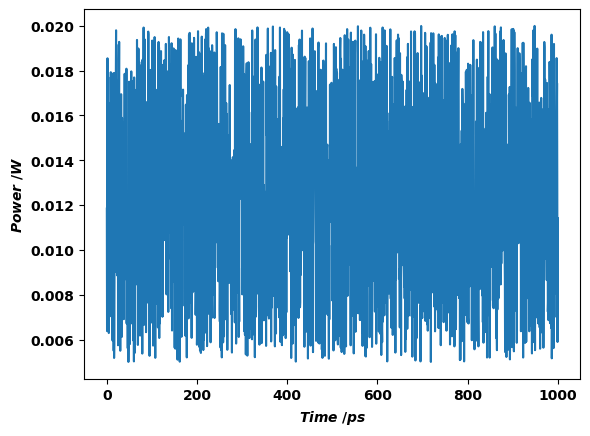

In [22]:
def q(A, q0, tau, Ea):

    # Absorción grafeno. 

    return q0/(1+np.abs(A)**2*tau/Ea)


def g(A, T, g0, Ps):

    # Ganancia Erbio

    return g0/(1+np.trapz(np.abs(A)**2, T)/(1000*1e-12*Ps))

#Parametros de la simulación.


q0 = 0.03

taua = 100e-15

Ea = 770e-9

n = 2**11

omegag = 3.75*1e12  # THz

gamma = 1.2e-3  # nonlinear coefficient [1/W/m]

Ps = 0.538e-3

g0 = 3.5

c = 299792458  # speed of light

L = 2  # Longitud fibra

loss = 0

alpha = np.log(10**(loss/10))  # attenuation coefficient

D = 57.0*1e-12*1e9*1e-3  # ps/nm/km

wl = 1550e-9  # Lambda

beta2 = -wl**2/(2*np.pi*c)*D

t = np.linspace(0, 1000, n)*1e-12

dt = 1000*1e-12/len(t)

A = np.random.uniform(low=0.005, high=0.02, size=n) # Seed

plt.plot(t*1e12, A)
plt.xlabel('$Time$ $/ps$')
plt.ylabel('$Power$ $/W$')

In [4]:
def fourier_split1(psi0, T, gamma, beta2, deltat, lenght,NN):

    N = len(psi0)

    dz = 0.01

    dw = np.pi/(N*deltat)

    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])

    psi = psi0

    for i in range(NN):

        zz = 0

        while zz <= lenght:

            D = -alpha/2+1j*V**2*beta2/2+g(psi, T, g0, Ps)*(1-V**2/omegag**2)

            UD = np.exp(dz*D*0.5, dtype=complex)

            step1 = fourierI(UD*fourierT(psi))

            N = 1j*np.abs(psi)**2*gamma

            UN = np.exp(dz*N, dtype=complex)

            step2 = UN*step1

            step3 = fourierI(UD*fourierT(step2))

            psi = step3

            zz += dz

        
        psi=(1-q(A, q0, taua, Ea))*psi*0.85

    return psi

In [122]:
N = 2000
k = fourier_split1(A, t, gamma, beta2, dt, L,N)

(0.0, 1.7e-10)

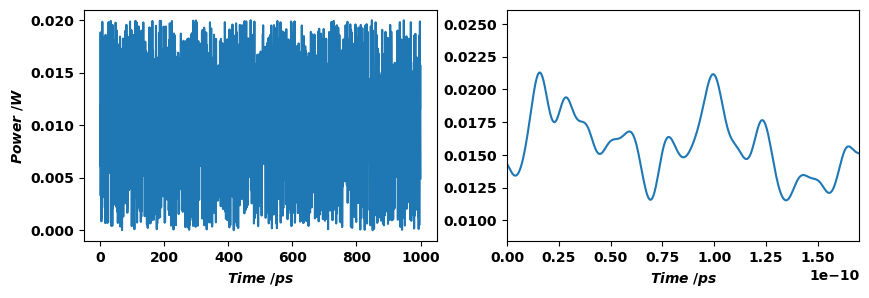

In [124]:
f = plt.figure(figsize=(10, 3))


plt.subplot(121)

plt.plot(t*1e12, A)
plt.xlabel('$Time$ $/ps$')
plt.ylabel('$Power$ $/W$')


plt.subplot(122)
plt.plot(t, np.abs(k)**2)
plt.xlabel('$Time$ $/ps$')
plt.xlim(0,170e-12)

# Método 2. Esta basado en el articulo:
Robust split-step Fourier methods for simulating
the propagation of ultra-short pulses in single-
and two-mode optical communication fibers

In [23]:
def fourier_split(psi0,T,gamma,beta2,deltat, length,NN,steps):

    N = len(psi0)

    dz = length/steps

    dw = 2*np.pi/(N*deltat)

    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])

    psi = psi0


    for i in range(NN):

        zz = 0

        #Ciclo de Erbio

        while zz <= length:

            D = -alpha/2+1j*V**2*beta2/2+g(psi, T, g0, Ps)*(1-V**2/omegag**2)*0.5

            UD = np.exp(dz*D*0.5, dtype=complex)

            A_ast = fourierI(UD*fourierT(psi))     

            N = 1j*gamma*(np.abs(A_ast)**2)

            UN = np.exp(dz*N, dtype=complex)

            A_aast= A_ast+dz*N*A_ast

            step3 = fourierI(UD*fourierT(A_aast))
        
            psi = step3

            zz += dz


        # Absorción
        
        psi=(1-q(A, q0, taua, Ea))*psi*0.85

    return psi


In [31]:
N = 10000
k = fourier_split(A, t, gamma, beta2, dt, L,N,100)

Text(0.5, 0, '$Time$ $/ps$')

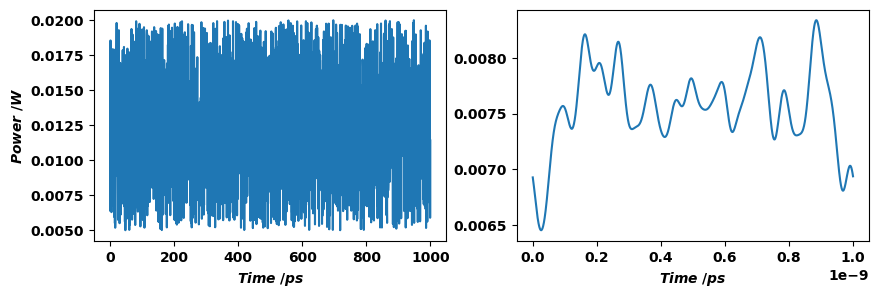

In [32]:
f = plt.figure(figsize=(10, 3))


plt.subplot(121)

plt.plot(t*1e12, A)
plt.xlabel('$Time$ $/ps$')
plt.ylabel('$Power$ $/W$')



plt.subplot(122)
plt.plot(t, np.abs(k)**2)
plt.xlabel('$Time$ $/ps$')
#plt.xlim(0,170e-12)

# Investigations of switchable ﬁber soliton laser mode-locked by carbon nanotubes

Text(0, 0.5, 'Normalized gain spectrum')

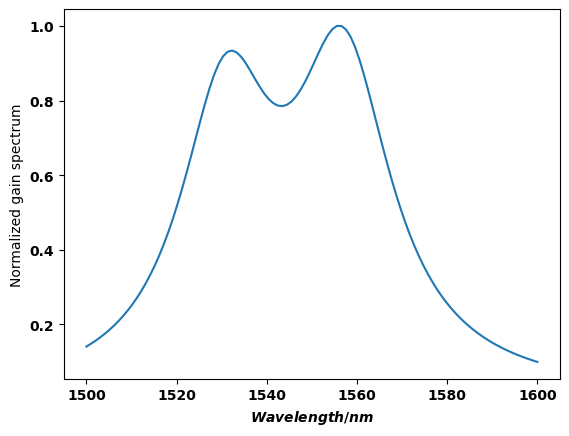

In [19]:
Omega = 10e12
c = 299792458
lambda1 = 1531e-9
lambda2 = 1557e-9
omega1 = (2*np.pi*c)/lambda1
omega2 = (2*np.pi*c)/lambda2
wl = np.linspace(1.5e-6, 1.6e-6, 100)
omega = (2*np.pi*c)/wl

# Parametros Erbio

g0=6
omegag=25e-9
gammae=3e-3
Le=5
beta2e=11.5*(1e-12)**2*1e-3
Es=32e-9

# Parametros SMF

gammas=1.3e-3
beta2s=-21.6*(1e-12)**2*1e-3
Ls=55

# Parametros absorbedor saturable

alpha0=0.15
alphans=0.5
Isat=12.7e6*1e4

def g(g0,t,A):

    return g0*np.exp(-np.trapz(np.abs(A)**2,t)/Es)



def gain(omega, N1,N2):

    return N1/(1+((omega-omega1)/Omega)**2)+N2/(1+((omega-omega2)/Omega)**2)

y=gain(omega, 0.9,1)

plt.plot(wl*1e9, y/max(y))

plt.xlabel('$Wavelength/nm$')
plt.ylabel('Normalized gain spectrum')



In [33]:
def propErbio(psi0,T,deltat,steps):

    N = len(psi0)

    dz = Le/steps

    dw = 2*np.pi/(N*deltat)

    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])

    psi = psi0


    while zz <= Le:

        D = -1j*V**2*beta2e/2+g(g0,T,A)*(1-V**2/omegag**2)*0.5

        UD = np.exp(dz*D*0.5, dtype=complex)

        A_ast = fourierI(UD*fourierT(psi))     

        N = 1j*gammae*(np.abs(A_ast)**2)

        UN = np.exp(dz*N, dtype=complex)

        A_aast= A_ast+dz*N*A_ast

        step3 = fourierI(UD*fourierT(A_aast))
    
        psi = step3

        zz += dz


        # Absorción
    return psi

def propSMF(psi0,deltat,steps):

    N = len(psi0)

    dz = Ls/steps

    dw = 2*np.pi/(N*deltat)

    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])

    psi = psi0


    while zz <= Ls:

        D = -1j*V**2*beta2s/2

        UD = np.exp(dz*D*0.5, dtype=complex)

        A_ast = fourierI(UD*fourierT(psi))     

        N = 1j*gammas*(np.abs(A_ast)**2)

        UN = np.exp(dz*N, dtype=complex)

        A_aast= A_ast+dz*N*A_ast

        step3 = fourierI(UD*fourierT(A_aast))
    
        psi = step3

        zz += dz

        # Absorción
    return psi

def sat_ab(psi0,t):
    
    return (1-(alphans+alpha0/(1+np.trapz(np.abs(A)**2,t)/Isat)))*psi0

def filter(psi0):

    return fourierI(fourierT(psi0)*gain)

def prop(psi0,T,deltat,N,steps):
    
    psi=psi0

    
    for i in range(N):




# A Fast Method for Nonlinear Schrödinger Equation.

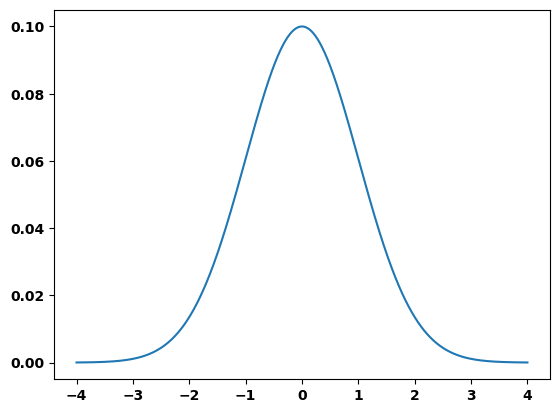

In [26]:
alpha = 0.17*np.log(10)/10
beta2 = -2.549*(1e-12)**2*1e-3
beta3 = 0
gamma = 2.4*1e-3
Tr = 0
L = 80*1e3
P0 = 10*1e-3
T0 = 50*1e-12
N = 2**10
L=80e3
T = np.linspace(-200, 200, N)*1e-12
u0 = np.sqrt(P0)*np.exp(-T**2/(2*T0**2))
plt.plot(T/T0, u0)

# Para comparar con el método propuesto de este articulo implemento un codigo de otro articulo:

# Robust split-step Fourier methods for simulating the propagation of ultra-short pulses in sigle and two-mode...

In [123]:
def fourier_split(psi0, gamma, beta2, beta3, Tr,w0, deltat, length,steps):

    N = len(psi0)

    dz = length/steps

    dw = np.pi/(N*deltat)

    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])

    psi = psi0

    D = -alpha/2+1j*V**2*beta2/2+1j*beta3/6*V**3

    UD = np.exp(dz*L*0.5, dtype=complex)

    S=1/w0

    for i in range(steps):


        A_ast = fourierI(UD*fourierT(psi))                    

        N = 1j*gamma*(np.abs(A_ast)**2)
            #+1j*S*np.conjugate(A_ast)*fourierI(-1j*V*fourierT(A_ast))
            #+(1j*S-Tr)*fourierI(-1j*V*fourierT(np.abs(A_ast)**2)))

        A_aast= A_ast+dz*N*A_ast

        step3 = fourierI(UD*fourierT(A_aast))
        
        psi = step3

    return psi

In [125]:
N = 2**12
T = np.linspace(-200, 200, N)*1e-12
beta3=1.6666666666666665e-40
Tr=3e-15
T0=5e-12
beta2=0
alpha=0.02*np.log(10)/10
deltat=400/N*1e-12
c = 299792458  # speed of light
WL=1550e-9
w0=(2*np.pi*c/(WL))  #Frequencies.
length=T0**3/(beta3)*6
P0 = 10*1e-3
gamma = 2.4*1e-3
T = np.linspace(-200, 200, N)*1e-12
deltat=400e-12/len(T)
u0 = np.sqrt(P0)*np.exp(-T**2/(2*T0**2))
sol=fourier_split(u0, gamma, beta2, beta3, Tr,w0, deltat, length,1000)


/tmp/ipykernel_9095/1964911321.py:15: RuntimeWarning: overflow encountered in exp
  UD = np.exp(dz*L*0.5, dtype=complex)
/tmp/ipykernel_9095/1964911321.py:22: RuntimeWarning: invalid value encountered in multiply
  A_ast = fourierI(UD*fourierT(psi))


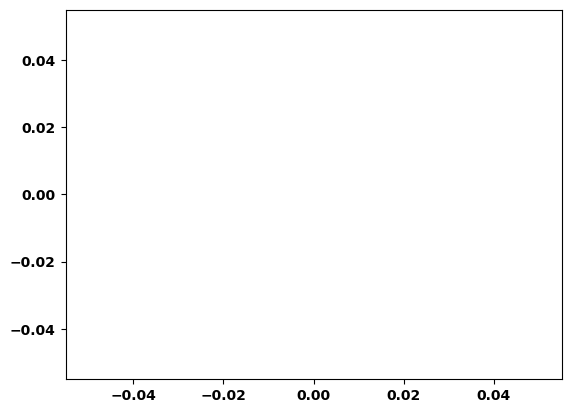

In [121]:
plt.plot(T,np.abs(sol)**2)

In [58]:
Ld

125000.0

In [45]:
pasos=np.arange(50,10000,50)
resul=[]
for j in pasos:
    sol2=fourier_split(u0, gamma, beta2, deltat,Ld*5,j)
    resul.append(np.trapz(np.abs(sol2-sol)**2,T)/np.trapz(np.abs(sol)**2,T))

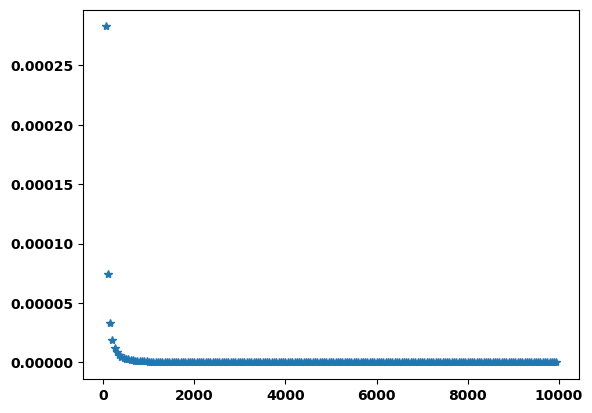

In [47]:
plt.plot(pasos,resul,'*')

In [146]:
def fourier_new(A0, L, w0, dt, stepsz, n):

   
    dz = L/stepsz
    N = len(A0)
    dw = np.pi/(N*dt)
    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])
    Ai = A0
    w=1.

    Ai_s=[Ai]

    for i in range(1,n):

        Ai_s.insert(i,0)
   

    def L_op(A):

        L = -alpha/2+1j*V**2*beta2/2-1j*V**2*beta3/6

        UL = np.exp(dz*D*0.5, dtype=complex)

        return fourierI(UL*fourierT(A))

    As = np.array([[3/2, -1/2, 0, 0, 0], [23/12, -16/12, 5/12, 0, 0], [55/24, -
                  59/24, 37/24, -9/24, 0], [1901/720, -2774/720, 2616/720, -1274/720, 251/720]])
    Bs = np.array([[1/2, 1/2, 0, 0, 0], [5/12, 8/12, -1/12, 0, 0], [9/24,
                  19/24, -5/24, -1/24, 0], [251/720, 646/720, -264/720, 106/720, -19/720]])
    Cs= np.array([[1/4,2/4,1/4,0,0,0],[5/24,13/24,7/24,-1/24,0,0],[9/48,28/48,14/48,-4/48,1/48,0],[251/1440,897/1440,382/1440,-158/1440,87/1440,-19/1440]])

    def N(A):
        return 1j*gamma*(np.abs(A)**2+1j/(A*w0)*(fourierI(-1j*w*fourierT(np.abs(A)**2*A)))-Tr*fourierI(-1j*w*fourierT(np.abs(A)**2)))

    for j in range(0,stepsz):

        ubar_1 = L_op(A)
        ubar_2=np.exp(dz*(sum(As[n,j]*N(Ai_s[j]) for i in range(len(Ai_s)))))*ubar_1
        ubar_3=L_op(ubar_2)
        u_2=np.exp(dz*(As[n,0]*N()+sum(As[n,i]*N(i) for i in Ai_s)))*ubar_1


In [148]:
As = np.array([[3/2, -1/2, 0, 0, 0], [23/12, -16/12, 5/12, 0, 0], [55/24, -
              59/24, 37/24, -9/24, 0], [1901/720, -2774/720, 2616/720, -1274/720, 251/720]])
Bs = np.array([[1/2, 1/2, 0, 0, 0], [5/12, 8/12, -1/12, 0, 0], [9/24,
              19/24, -5/24, -1/24, 0], [251/720, 646/720, -264/720, 106/720, -19/720]])
Bs

array([[ 0.5       ,  0.5       ,  0.        ,  0.        ,  0.        ],
       [ 0.41666667,  0.66666667, -0.08333333,  0.        ,  0.        ],
       [ 0.375     ,  0.79166667, -0.20833333, -0.04166667,  0.        ],
       [ 0.34861111,  0.89722222, -0.36666667,  0.14722222, -0.02638889]])

In [16]:
a=[1]

a.insert(,5)

[1, 5]

In [ ]:
def fourier_split(psi0, T, gamma, beta2, deltat, lenght,NN):

    N = len(psi0)

    dz = 0.01

    dw = np.pi/(N*deltat)

    V = np.array([j*dw for j in range(-int(N/2), int(N/2))])

    psi = psi0

   

    for i in range(NN):

      
        zz = 0

        while zz <= lenght:

            D = -alpha/2+1j*V**2*beta2/2+g(psi, T, g0, Ps)*(1-V**2/omegag**2)

            UD = np.exp(dz*D*0.5, dtype=complex)

            step1 = fourierI(UD*fourierT(psi))

            N = 1j*np.abs(psi)**2*gamma

            UN = np.exp(dz*N, dtype=complex)

            step2 = UN*step1

            step3 = fourierI(UD*fourierT(step2))

            psi = step3

            zz += dz

         
        
        
        psi=(psi-q(A, q0, taua, Ea)*psi)*0.85

    return psi